In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# *** Loading the data ***
def normalize_frame(df):
    new = df.rename(columns={"Province/State": "State", "Country/Region": "Country"})
    new = new.drop(["State", "Lat", "Long"], axis=1)
    new = new.groupby("Country").sum()
    return new

def get_normalized_frame(path: str):
    return normalize_frame(pd.read_csv(path))

confirmed = get_normalized_frame("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
deaths = get_normalized_frame("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
recovered = get_normalized_frame("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")

In [8]:
# *** Accessing data ***
def list_countries():
    return confirmed.index.values.tolist()


def get_confirmed(country: str):
    return confirmed.loc[country]


def get_deaths(country: str):
    return deaths.loc[country]


def get_recovered(country: str):
    return recovered.loc[country]


def get_active(country: str):
    return get_confirmed(country) - get_deaths(country) - get_recovered(country)


def select_thresh(arr, thresh=100):
    for i, v in enumerate(arr):
        if v >= thresh:
            return arr[i:]
    return []


def get_cases(country: str, mode="a", thresh=100):
    if mode == 'a' or mode == 'active':
        series = get_active(country)
    elif mode == 'c' or mode == 'confirmed':
        series = get_confirmed(country)
    else:
        raise ValueError(f'Mode {mode} not recognised.')
    
    return select_thresh(series, thresh)
    
def log_evolution(country: str, mode="a", thresh=100):
    return np.log10(get_cases(country, mode=mode, thresh=thresh))

In [52]:
# *** Plotting ***

def plot_time(country: str, mode="active", thresh=100):
    series = log_evolution(country, mode=mode, thresh=thresh)
    
    plt.scatter(np.arange(len(series)), series,
        label=country, s=12
    )

    
def plot_time_mult(lst: list, mode='active', thresh=100):
    for cnt in lst:
        plot_time(cnt, mode=mode, thresh=thresh)
        
    plt.legend(bbox_to_anchor=(1.4,1))

    
    plt.title(mode)
    plt.xlabel(f'Day since detection of {thresh} cases.')
    plt.ylabel('Number of cases (log).')
    
    
def plot_phase(country: str, mode: str='active', thresh=100):
    series = get_cases(country, mode=mode, thresh=thresh).values
    cases = series[2:]
    increase = cases - series[:-2]
    
    plt.scatter(np.log10(cases), np.log10(increase), label=country, s=12)


def plot_phase_mult(lst: list, mode: str='active', thresh=100):
    for cnt in lst:
        plot_phase(cnt)
    plt.legend(bbox_to_anchor=(1.4,1))
    plt.xlim(2, 6)
    plt.ylim(1, 5)
    plt.title(mode)
    plt.xlabel("Number of cases (log)")
    plt.ylabel("Daily increase (log)")


def reproduction_number(ys: list):
    xs = np.arange(len(ys))
    
    coeffs, cov = np.polyfit(xs, ys, 1, cov=True)

    mu = coeffs[0]
    pm = np.sqrt(cov[0, 0])
    return 10**(mu-1*pm), 10**(mu+1*pm)


def plot_reproduction(cnt: str, mode="a", thresh=100):
    arr = log_evolution(cnt, mode=mode, thresh=thresh)
    x, ymin, ymax = [], [], []

    for days in range(-30, -3, 1):
        view = arr[(days-4):(days+3)]

        if len(view) < 7:
            continue
    
        x.append(days)
        
        y1, y2 = reproduction_number(view)
    
        ymin.append(y1)
        ymax.append(y2)
    
    plt.fill_between(x, ymin, ymax, alpha=0.5, label=cnt)
    

def plot_repr_mult(lst: list, mode="a", thresh=100):
    for cnt in lst:
        plot_reproduction(cnt, mode=mode, thresh=thresh)

    plt.legend(bbox_to_anchor=(1.4,1))
    plt.xlim(-25, 0)

    plt.ylabel("Reproduction number")
    plt.xlabel("Time (days)")

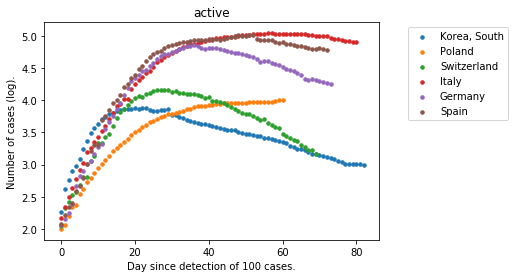

In [47]:
countries_list = [
    'Korea, South', 
    'Poland', 
    'Switzerland', 
    #'Japan',
    'Italy', 
    'Germany',
    #'France',
    'Spain',
    # 'United Kingdom', 
    #'US',
]

plot_time_mult(countries_list, mode='active')

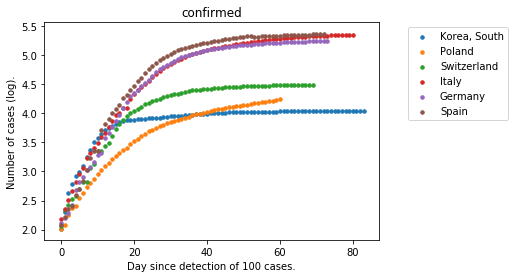

In [48]:
plot_time_mult(countries_list, mode='confirmed')

<ipython-input-46-d9cf2ec395d9>:28: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(cases), np.log10(increase), label=country, s=12)
<ipython-input-46-d9cf2ec395d9>:28: RuntimeWarning: invalid value encountered in log10
  plt.scatter(np.log10(cases), np.log10(increase), label=country, s=12)


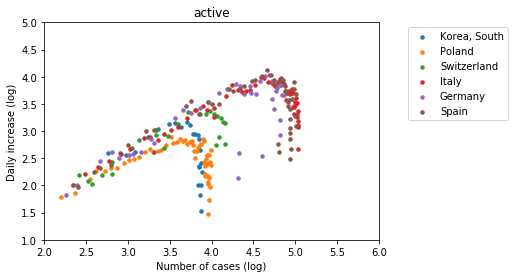

In [49]:
plot_phase_mult(countries_list, mode='active')

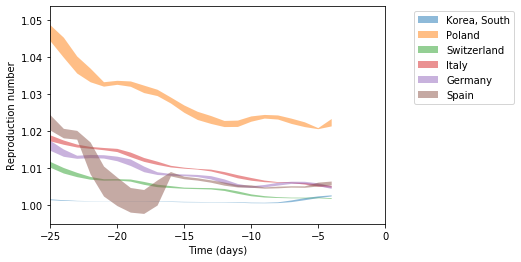

In [57]:
plot_repr_mult(countries_list, mode="c")

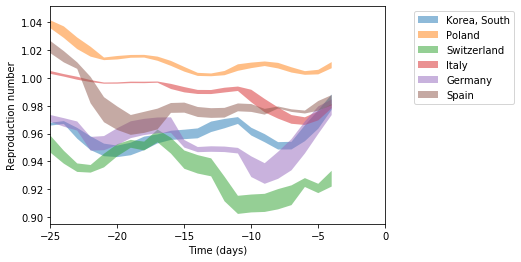

In [58]:
plot_repr_mult(countries_list, mode="a")